In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import  scipy.stats as stats

# Rejection

- Standard rejection algorithm

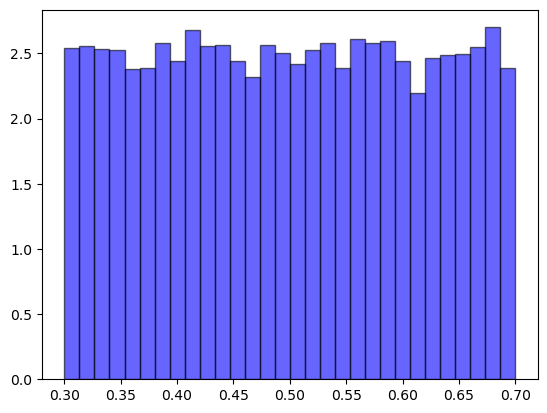

In [18]:

# Define the desired interval B = [0.3, 0.7] over uniform distribution
lower_bound = 0.3
upper_bound = 0.7

# Generate samples using rejection sampling
samples = []
while len(samples) < 10000:  # Generate 10,000 valid samples ( A)
    X = np.random.uniform(0, 1)  # Sample from U(0,1)
    if lower_bound <= X <= upper_bound:  # Accept only if within B
        samples.append(X)

# Plot histogram of accepted samples
plt.hist(samples, bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.show()


- Box-Muller with rejection

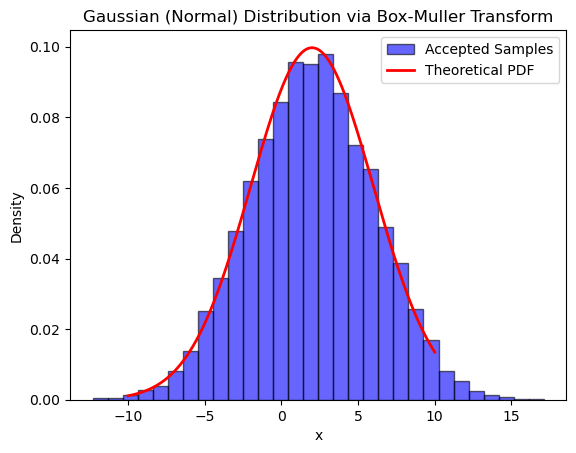

In [19]:

from scipy.stats import norm
# Generate samples using rejection sampling without sin cos
sigma=4
mu=2
samples_x = []
samples_y = []
while len(samples_x) < 10000:  # Generate 10,000 valid samples ( A)
    U = np.random.uniform(-1, 1, )
    V = np.random.uniform(-1, 1, )
    S=U**2+V**2
    if S<=1:  # Accept only if within B
        samples_x.append(U*np.sqrt(-2 * np.log(S)/S))
        samples_y.append(V*np.sqrt(-2 * np.log(S)/S))
# Plot histogram of accepted samples mu+sigma*X~N(mu,sigma2)
samples_x = np.array(samples_x) * sigma + mu
plt.hist(samples_x, bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
x_vals = np.linspace(-10, 10, 1000)
pdf = norm.pdf(x_vals, mu, sigma)
plt.plot(x_vals, pdf, 'r-', lw=2, label="Theoretical PDF")

# Labels and Title
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Gaussian (Normal) Distribution via Box-Muller Transform")
plt.legend()
plt.show()
plt.show()


# **Accept-Reject algorithm**

# Target Density

Consider the function

$$
f(x) =  e^{-x^4}
$$

This function is known only up to a multiplicative constant.the pdf given by 

$$
p(x) = \frac{f(x)}{Z},
$$

where

$$
Z = \int_{0}^{\infty} f(x) \, dx.
$$


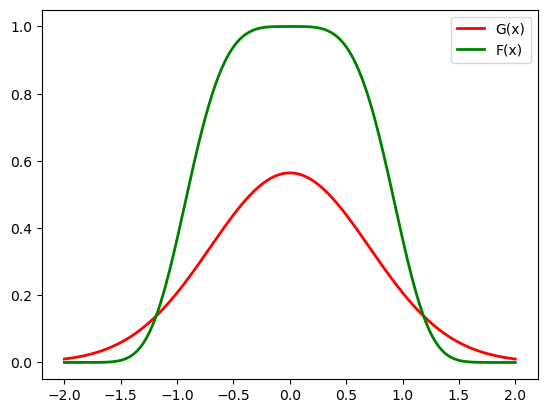

In [52]:

# Target distribution: f(x) ∝ e^(-x^4) estimated with kernel or histograms for example , attention, it is proportional, not pdf of f!!! look after 
mu=0
sigma2=0.5
def f(x):
    return np.exp(-x**4)

# Define the reference density g(x, teta)
def g(x, mu, sigma2):
    return np.exp(-(x - mu)**2 / (2 * sigma2)) / np.sqrt(2 * np.pi * sigma2)

#set our event space w
x_vals = np.linspace(-2, 2, 1000)
#g is pdf so you can use this notation 
pdf_g=g(x_vals,mu,sigma2)

plt.plot(x_vals, pdf_g, 'r-', lw=2,label="G(x)")  # Add label for legend
# 
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

In [53]:
#find  M such that M*G(x)>=F(x) so M= sup f/G ( find with max)
M=np.max(f(x_vals)/pdf_g)
M

np.float64(2.275875066329523)

In [54]:
#analytically find M by maximising f/G and then M*=
print(np.sqrt(2 * np.pi*sigma2)*np.exp(1/(16*sigma2**2)))
#analytically find sigma2 by minimising log(M)
sigma2=0.5

2.275875794468747


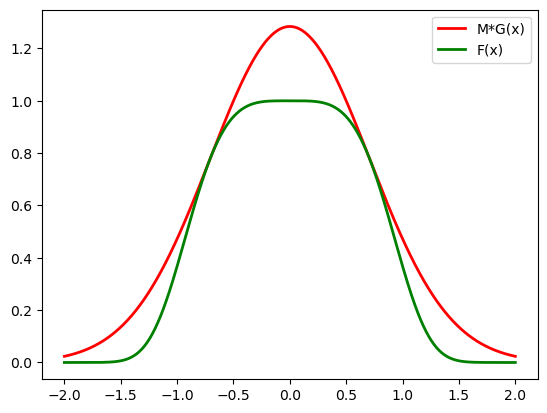

In [55]:
#find minimal M such that M*G(x)>=F(x)
M=np.max(f(x_vals)/pdf_g)
plt.plot(x_vals, pdf_g*M, 'r-', lw=2,label="M*G(x)")  # Add label for legend
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

In [58]:
#implement algo 
samples = []
while len(samples) < 10000: 
    U = np.random.uniform(0, 1, )
    V1 = np.random.uniform(-1, 1, )
    V2 = np.random.uniform(-1, 1, )
    S=V1**2+V2**2
    if S<=1:  # x sampled from normal using rejection and box muller , 
         x=V1*np.sqrt(-2 * np.log(S)/S)
         x=x*np.sqrt(sigma2)
        #  or use : x=np.random.normal(0,np.sqrt(sigma2),1)[0].item()
         if U<=f(x)/(M*g(x,mu,sigma2)):  # Accept-reject algo 
           samples.append(x)

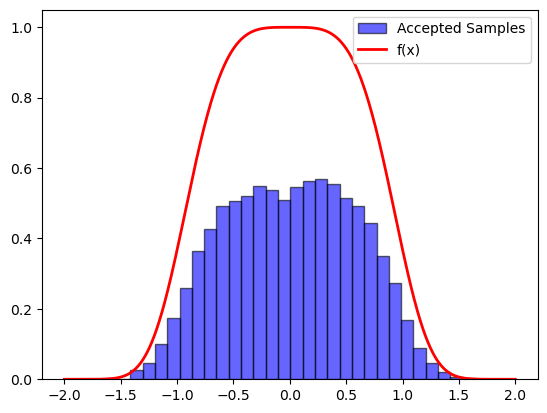

In [59]:
#plot accepted samples with f(x_vals)
plt.hist(np.array(samples), bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.plot(x_vals, f(x_vals), 'r-', lw=2,label="f(x)")
plt.legend()
plt.show()
#normal behaviour as f is not pdf but proportional pdf so find constant Z that will normalise f


In [60]:
from scipy.integrate import quad

Z, error = quad(f, -np.inf, np.inf)
print("Integral of f over (-∞, ∞):", Z,"so since not 1 it is not a pdf so our aim is not divide pdf by this Z")

Integral of f over (-∞, ∞): 1.8128049541109543 so since not 1 it is not a pdf so our aim is not divide pdf by this Z


Integral of f_density over (-∞, ∞): 1.0 ,good!


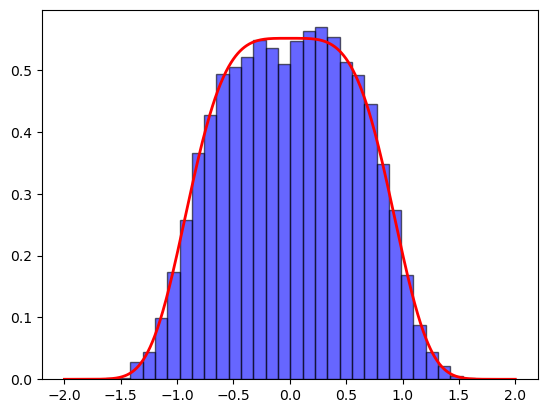

In [61]:
def f_density(x):
    #normalise and it becomes pdf of f
    return np.exp(-x**4)/Z

#verify that f is pdf 
integral, error = quad(f_density, -np.inf, np.inf)
print("Integral of f_density over (-∞, ∞):", integral,",good!")

plt.hist(np.array(samples), bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.plot(x_vals, f_density(x_vals), 'r-', lw=2)

let's create a function with the aim of finding the constant M numerically:

$$
M(x,\theta)=\inf_{\theta \in \mathbb{R}^d} \sup_{x \in \mathbb{R}} \frac{f(x)}{g(x,\theta)}
$$


In [66]:
# Define the function M as the maximum of the ratio f(x)/g(x,teta)

def M( params,support_x, f_pdf):
    pdf_g = g(support_x, *params)#UNPACK params which are init_params FROM BELOW
    ratio = f_pdf / pdf_g
    return np.max(ratio)

number_observations = 1000
support = (-2, 2)
support_x = np.linspace(support[0], support[1], number_observations)
f_pdf = f(support_x) 

# Initial guess for [mu, sigma2] AS N(0,1)
init_params = [0.0, 1]
# Use  a derivative-free method (Nelder-Mead)
result = minimize(M, x0=init_params, args=(support_x, f_pdf),
                  method='Nelder-Mead', options={'disp': False})

print("optimal params:",np.round(result.x,1))
print("min M:",result.fun)



optimal params: [-0.   0.5]
min M: 2.275874403711238


same results as analytically

# Target Density

Consider the function

$$
f(x) = x^3 \, e^{-x^2/2}, \quad x \ge 0.
$$




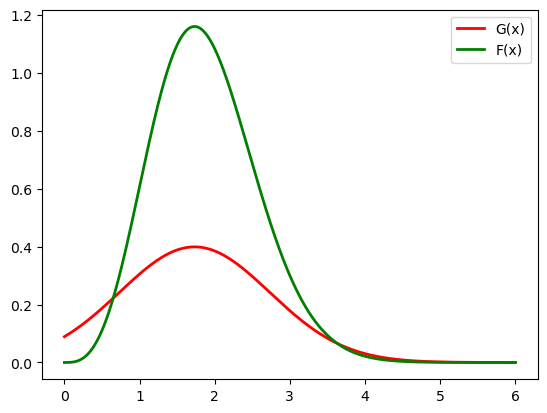

In [115]:
def f(x):
    return x**3*np.exp(-x**2/2)

mu=np.sqrt(3)
sigma2=1.0
# Proposal distribution: Normal N(sqrt3,1)
def g(x,mu,sigma2):
    return np.exp(-(x-mu)**2 /(2*sigma2)) / np.sqrt(2 * np.pi*sigma2)  


#set our event space w
x_vals = np.linspace(0, 6, 1000)
#g is pdf so you can use this notation 
pdf_g=g(x_vals,mu,sigma2)

plt.plot(x_vals, pdf_g, 'r-', lw=2,label="G(x)")  # Add label for legend
# 
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

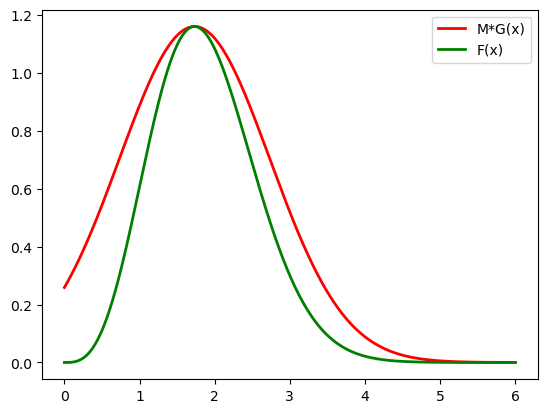

In [116]:
#find minimal M such that M*G(x)>=F(x)
M=np.max(f(x_vals)/pdf_g)
plt.plot(x_vals, pdf_g*M, 'r-', lw=2,label="M*G(x)")  # Add label for legend
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

In [117]:
#in f(x) select your parameters so that M will be minimal ( here i did adhoc mu=1.75 for f(x))
M

np.float64(2.9062229131299357)

In [118]:
#implement algo 
samples = []
while len(samples) < 10000: 
    U = np.random.uniform(0, 1, )
    V1 = np.random.uniform(-1, 1, )
    V2 = np.random.uniform(-1, 1, )
    S=V1**2+V2**2
    if S<=1:  # x sampled from normal using rejection and box muller , equivalently you can do this : # x=np.random.normal(0,1,1)[0].item() just with library
        x=V1*np.sqrt(-2 * np.log(S)/S)
        x=x+mu
        if U<=f(x)/(M*g(x,mu,sigma2)):  # Accept-reject algo 
           samples.append(x)

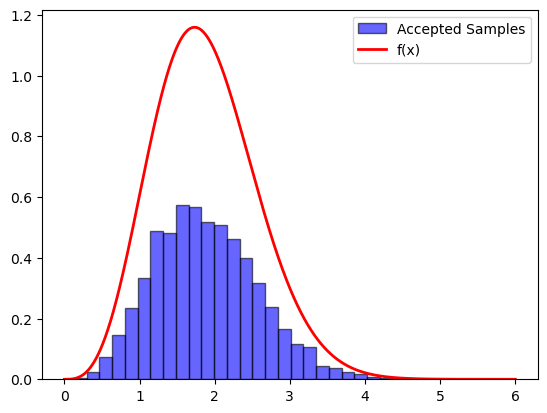

In [119]:
#plot accepted samples with f(x_vals)
plt.hist(np.array(samples), bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.plot(x_vals, f(x_vals), 'r-', lw=2,label="f(x)")
plt.legend()
plt.show()

In [120]:
from scipy.integrate import quad

Z, error = quad(f, 0, np.inf)
print("Integral of f over (0, ∞):", Z,"so since not 1 it is not a pdf so our aim is not divide pdf by this Z")

Integral of f over (0, ∞): 2.0 so since not 1 it is not a pdf so our aim is not divide pdf by this Z


Integral of f_density over (-∞, ∞): 1.0 ,good!


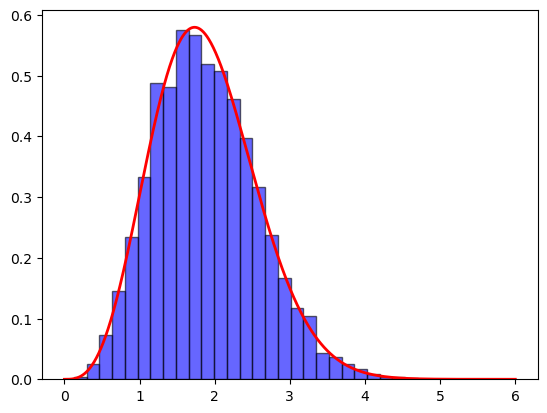

In [121]:
def f_density(x):
    #normalise and it becomes pdf of f
    return x**3*np.exp(-x**2/2)/Z

#verify that f is pdf 
integral, error = quad(f_density, 0, np.inf)
print("Integral of f_density over (-∞, ∞):", integral,",good!")

plt.hist(np.array(samples), bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.plot(x_vals, f_density(x_vals), 'r-', lw=2,label="M*G(x)")

In [123]:
# Define the function M as the maximum of the ratio f(x)/g(x,teta)

def M( params,support_x, f_pdf):
    pdf_g = g(support_x, *params)#UNPACK params which are init_params FROM BELOW
    ratio = f_pdf / pdf_g
    return np.max(ratio)

number_observations = 1000
support = (0, 6)
support_x = np.linspace(support[0], support[1], number_observations)
f_pdf = f(support_x) 

# Initial guess for [mu, sigma2] AS N(0,1)
init_params = [0, 1]
# Use  a derivative-free method (Nelder-Mead)
result = minimize(M, x0=init_params, args=(support_x, f_pdf),
                  method='Nelder-Mead', options={'disp': False})

print("optimal params:",np.round(result.x,2))
print("min M:",result.fun)



optimal params: [1.78 0.7 ]
min M: 2.4394417358335936


he found different values of parameters leading to lower M

F normal g laplace

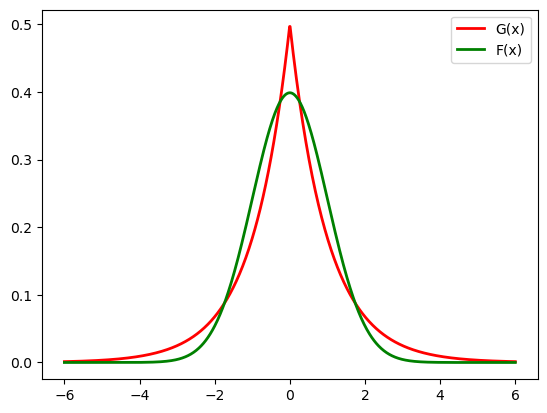

In [124]:

mu=0
sigma2=1

def f(x):
    return np.exp(-(x-mu)**2 /(2*sigma2)) / np.sqrt(2 * np.pi*sigma2) 


# Proposal distribution: Normal N(sqrt3,1)
def g(x):
    return 0.5*np.exp(-np.abs(x)) 


#set our event space w
x_vals = np.linspace(-6, 6, 1000)
#g is pdf so you can use this notation 
pdf_g=g(x_vals)

plt.plot(x_vals, pdf_g, 'r-', lw=2,label="G(x)")  # Add label for legend
# 
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

1.3154833154134895


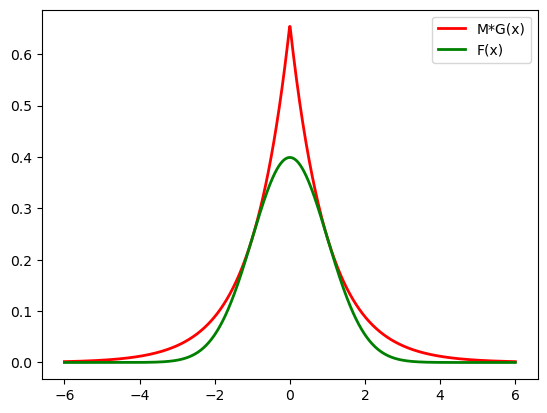

In [125]:
#find minimal M such that M*G(x)>=F(x)
M=np.max(f(x_vals)/pdf_g)
print(M)
plt.plot(x_vals, pdf_g*M, 'r-', lw=2,label="M*G(x)")  # Add label for legend
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

In [126]:
#analytically M=
2*np.exp(0.5)/(np.sqrt(2*np.pi))

np.float64(1.315489246958914)

In [54]:
#implement algo 
samples = []
while len(samples) < 10000: 
    U = np.random.uniform(0, 1, )
    U1 = np.random.uniform(0, 1, )
    U2 = np.random.uniform(0, 1, )
    
#parameters
    p=0.5
    S = np.array((U1 < p)).astype(int)*2-1
    Z=-np.log(U2)#exponential
    x=S*Z
    if U<=f(x)/(M*g(x)):  # Accept-reject algo 
           samples.append(x)

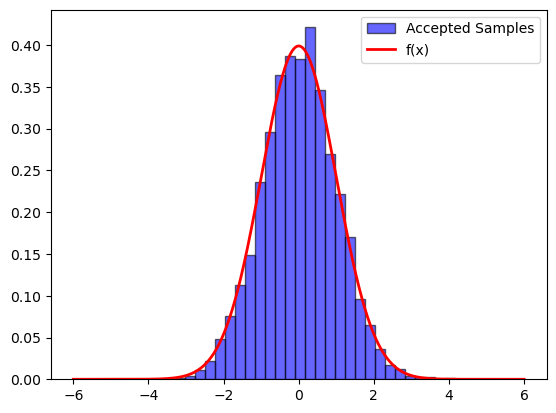

In [55]:
#plot accepted samples with f(x_vals)
plt.hist(np.array(samples), bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.plot(x_vals, f(x_vals), 'r-', lw=2,label="f(x)")
plt.legend()
plt.show()

In [56]:
from scipy.integrate import quad

Z, error = quad(f, -np.inf, np.inf)
print("Integral of f over (0, ∞):", Z,"good")

Integral of f over (0, ∞): 0.9999999999999998 good


F laplace g normal

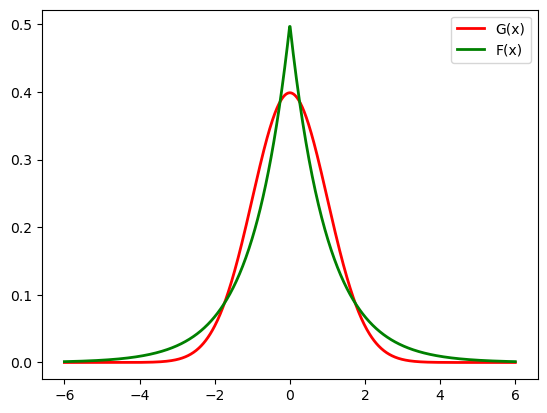

In [73]:

mu=0
sigma2=1

def g(x):
    return np.exp(-(x-mu)**2 /(2*sigma2)) / np.sqrt(2 * np.pi*sigma2) 


# Proposal distribution: Normal N(sqrt3,1)
def f(x):
    return 0.5*np.exp(-np.abs(x)) 


#set our event space w
x_vals = np.linspace(-6, 6, 1000)
#g is pdf so you can use this notation 
pdf_g=g(x_vals)

plt.plot(x_vals, pdf_g, 'r-', lw=2,label="G(x)")  # Add label for legend
# 
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

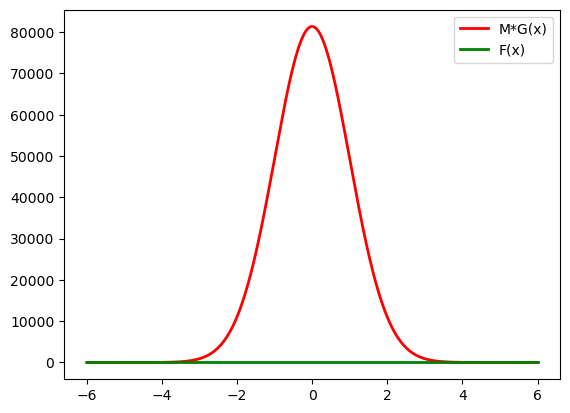

In [81]:
#find minimal M such that M*G(x)>=F(x)
M=np.max(f(x_vals)/pdf_g)
plt.plot(x_vals, pdf_g *M   , 'r-', lw=2,label="M*G(x)")  # Add label for legend
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()#not possible

In [75]:
(np.sqrt(2 * np.pi) / 2) * np.exp(-0.5) #it is min!!! so can not do this relationship 

np.float64(0.7601734505331403)

# Target Density

Consider exponential distribution

$$
f(x) =  \lambda  e^{-\lambda x}, \quad x \ge 0.
$$




optimal params: [0.46 2.54]
min M: 4.164822542370251


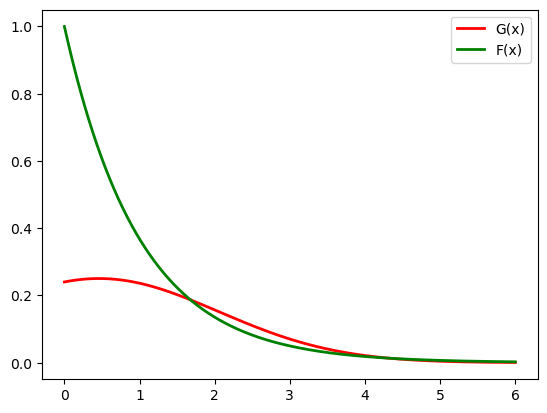

In [50]:
def f(x,lam):
    return lam*np.exp(-lam*x)
lam=1


def g(x,mu,sigma2):
    return np.exp(-(x-mu)**2 /(2*sigma2)) / np.sqrt(2 * np.pi*sigma2) 

# Define the function M as the maximum of the ratio f(x)/g(x,teta)

def M( params,support_x, f_pdf):
    pdf_g = g(support_x, *params)#UNPACK params which are init_params FROM BELOW
    ratio = f_pdf / pdf_g
    return np.max(ratio)

number_observations = 1000
support = (0, 6)
support_x = np.linspace(support[0], support[1], number_observations)
f_pdf = f(support_x,lam) 

# Initial guess for [mu, sigma2] AS N(0,1)
init_params = [0, 1]
# Use  a derivative-free method (Nelder-Mead)
result = minimize(M, x0=init_params, args=(support_x, f_pdf),
                  method='Nelder-Mead', options={'disp': False})

print("optimal params:",np.round(result.x,2))
print("min M:",result.fun)

mu=0.46
sigma2=2.54

#g is pdf so you can use this notation 
pdf_g= g(support_x,mu,sigma2)



plt.plot(support_x, pdf_g, 'r-', lw=2,label="G(x)")  # Add label for legend
# 
plt.plot(support_x, f_pdf, 'g-', lw=2,label="F(x)")
plt.legend()

4.164824413166326


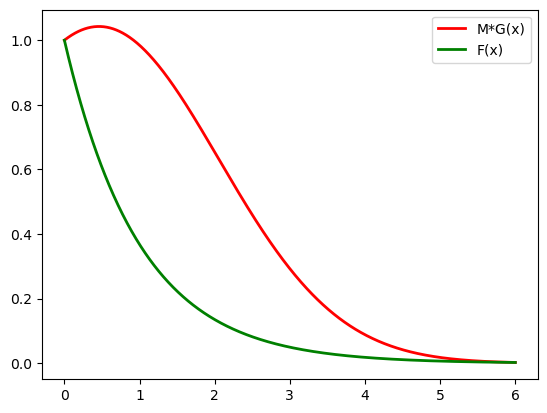

In [51]:
M=np.max(f_pdf/pdf_g)

print(M)
plt.plot(support_x, pdf_g*M, 'r-', lw=2,label="M*G(x)")  # Add label for legend
plt.plot(support_x, f(support_x,lam), 'g-', lw=2,label="F(x)")
plt.legend()

In [52]:
#implement algo 
samples = []
while len(samples) < 10000: 
    U = np.random.uniform(0, 1, )
    V1 = np.random.uniform(-1, 1, )
    V2 = np.random.uniform(-1, 1, )
    S=V1**2+V2**2
    if S<=1:  # x sampled from normal using rejection and box muller , equivalently you can do this : # x=np.random.normal(0,1,1)[0].item() just with library
        x=V1*np.sqrt(-2 * np.log(S)/S)
        x=np.abs(x*np.sqrt(sigma2)+mu)#x>=0 only
        if U<=f(x,lam)/(M*g(x,mu,sigma2)):  # Accept-reject algo 
           samples.append(x)

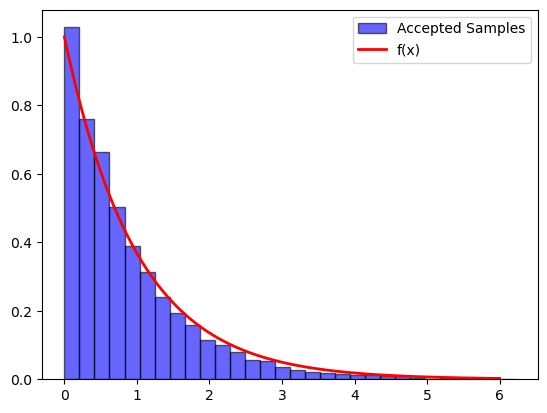

In [53]:
#plot accepted samples with f(x_vals)
plt.hist(np.array(samples), bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.plot(support_x, f_pdf, 'r-', lw=2,label="f(x)")
plt.legend()
plt.show()

optimal params: [1.   3.98]
min M: 2.356210624828382


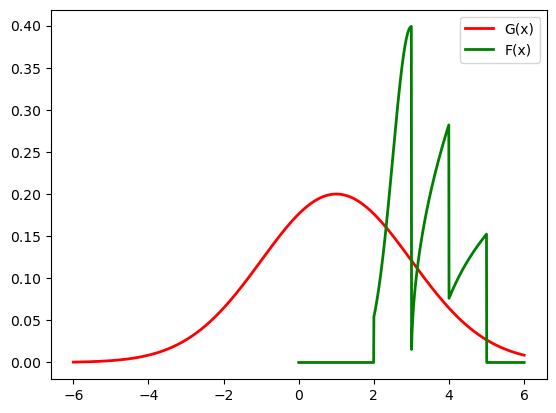

In [56]:

def _f(x):
    if x < -2:
        return 0
    elif x < 0:
        return stats.norm.pdf(x, loc=0, scale=1)
    elif x < 2:
        return 0.2 * np.sqrt(x)
    elif x < 4:
        return 0.11 * np.log(x)
    else:
        return 0

f = np.vectorize(_f, otypes=[float])

def g(x,mu,sigma2):
     return np.exp(-(x-mu)**2 /(2*sigma2)) / np.sqrt(2 * np.pi*sigma2) 

# # Define the function M as the maximum of the ratio f(x)/g(x,teta)

def M( params,support_x, f_pdf):
    pdf_g = g(support_x, *params)#UNPACK params which are init_params FROM BELOW
    ratio = f_pdf / pdf_g
    return np.max(ratio)

number_observations = 1000
support = (-6, 6)
support_x = np.linspace(support[0], support[1], number_observations)
f_pdf = f(support_x) 

# # Initial guess for [mu, sigma2] AS N(0,1)
init_params = [3, 2]
# Use  a derivative-free method (Nelder-Mead)
result = minimize(M, x0=init_params, args=(support_x, f_pdf),
                  method='Nelder-Mead', options={'disp': False})

print("optimal params:",np.round(result.x,2))
print("min M:",result.fun)

mu=1
sigma2=3.98

#g is pdf so you can use this notation 
pdf_g= g(support_x,mu,sigma2)



plt.plot(support_x, pdf_g, 'r-', lw=2,label="G(x)")  # Add label for legend
 
plt.plot(x_vals, f_pdf, 'g-', lw=2,label="F(x)")
plt.legend()

2.3594200909001692


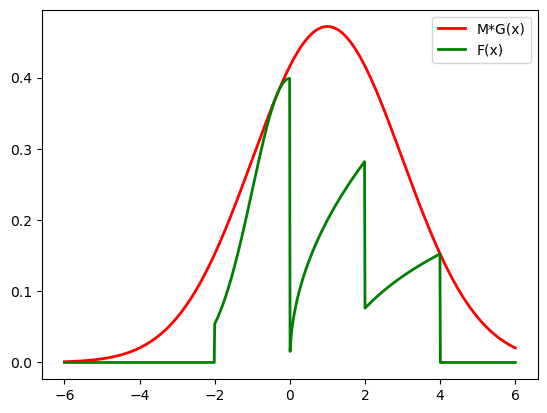

In [57]:
M=np.max(f_pdf/pdf_g)

print(M)
plt.plot(support_x, pdf_g*M, 'r-', lw=2,label="M*G(x)")  # Add label for legend
plt.plot(support_x, f(support_x), 'g-', lw=2,label="F(x)")
plt.legend()

In [64]:
#implement algo 
samples = []
while len(samples) < 10000: 
    U = np.random.uniform(0, 1, )
    V1 = np.random.uniform(-1, 1, )
    V2 = np.random.uniform(-1, 1, )
    S=V1**2+V2**2
    if S<=1:  # x sampled from normal using rejection and box muller , equivalently you can do this : # x=np.random.normal(0,1,1)[0].item() just with library
        x=V1*np.sqrt(-2 * np.log(S)/S)
        x=(x*np.sqrt(sigma2)+mu)
        if U<=f(x)/(M*g(x,mu,sigma2)):  # Accept-reject algo 
           samples.append(x)

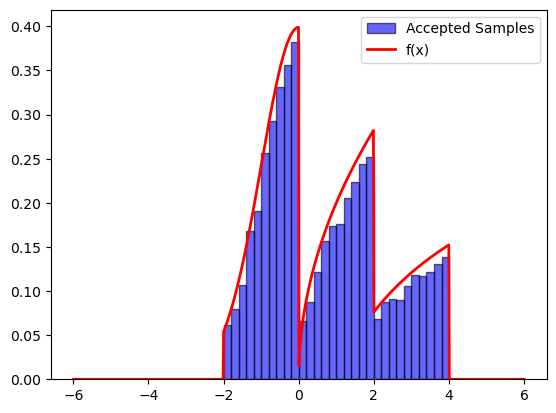

In [65]:
#plot accepted samples with f(x_vals)
plt.hist(np.array(samples), bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.plot(support_x, f_pdf, 'r-', lw=2,label="f(x)")
plt.legend()
plt.show()